In [3]:
import pyogrio
import pandas as pd
import pickle
from zipfile import ZipFile
import tempfile
import numpy as np
from pathlib import Path
import os
from collections import defaultdict
pd.set_option('display.max_columns',None)

# requires local installation of ireiat package using 
from ireiat.config import CACHE_PATH

### Purpose
Given the FAF5 regional association with counties and the county population, create an OD matrix (state_orig, county_orig, state_dest, county_dest)=tons

In [22]:
TARGET_FIELD = 'tons_2022'
TOLERANCE = 1e-5

In [5]:
county_pop_pdf = pd.read_csv(CACHE_PATH / 'raw/co-est2022-alldata.csv',dtype={'STATE':str,'COUNTY':str})

In [6]:
with open(CACHE_PATH / 'faf_id_to_county_areas','rb') as fp:
    faf_id_to_county_id_map = pickle.load(fp)

In [7]:
actual_state_county_to_pop_map = dict()
for row in county_pop_pdf.loc[county_pop_pdf['COUNTY']!='000'].itertuples(): # ignore state totals
    actual_state_county_to_pop_map[(row.STATE,row.COUNTY)]=row.POPESTIMATE2022

In [9]:
faf_id_to_county_id_population_map = defaultdict(dict)

# look up the county population within each faf zone
for faf_id, vals in faf_id_to_county_id_map.items():
    for (state_id, county_id), pct_county_in_faf in vals.items():
        faf_id_to_county_id_population_map[faf_id][(state_id, county_id)] = actual_state_county_to_pop_map[(state_id, county_id)]*pct_county_in_faf

In [10]:
faf_total_population_map = dict()
for faf_id, vals_dict in faf_id_to_county_id_population_map.items():
    faf_total_population_map[faf_id] = sum(vals_dict.values())

# check that the totals are equal
assert sum(actual_state_county_to_pop_map.values()) == sum(faf_total_population_map.values())

In [11]:
# determine the percentage of the faf demand that should be allocated to the county based on the allocation metric of interest
faf_id_to_county_percent_map = defaultdict(dict)
for faf_id, vals in faf_id_to_county_id_population_map.items():
    for (state_id, county_id), population_portion in vals.items():
        faf_id_to_county_percent_map[faf_id][(state_id, county_id)]=population_portion/faf_total_population_map[faf_id]

# confirm that all the faf ids have a "total" allocation that sums to 1 (within some tolerance)
assert all([abs(sum(pop_map.values())-1)<TOLERANCE for pop_map in faf_id_to_county_percent_map.values()])

In [12]:
target_path = CACHE_PATH / 'raw/faf5_demand.zip'
zip = ZipFile(target_path)
with tempfile.TemporaryDirectory() as tmpdirname:
    zip.extractall(path=tmpdirname)
    target_csvs = [f for f in zip.namelist() if f.endswith('csv')]
    faf_pdf = pd.read_csv(zip.open(target_csvs[0]),dtype={'dms_orig':str, 'dms_dest':str})
    zip.close()

In [13]:
# faf_mode_map = {
#     1:  'Truck',
#     2:	'Rail',
#     3:	'Water',
#     4:	'Air (include truck-air)',
#     5:	'Multiple modes & mail',
#     6:	'Pipeline',
#     7:	'Other and unknown',
#     8:	'No domestic mode',
# }

In [14]:
is_by_truck = faf_pdf['dms_mode']==1 # by truck
faf_truck_pdf = faf_pdf.loc[is_by_truck]
total_road_tons_od_pdf = faf_truck_pdf.groupby(['dms_orig','dms_dest'],as_index=False)[[TARGET_FIELD]].sum()

In [23]:
%%time
# create a (state_orig, county_orig, state_dest, county_dest) => tons map
county_od = defaultdict(float)
for row in total_road_tons_od_pdf.itertuples():
    constituent_orig_counties_map = faf_id_to_county_percent_map[row.dms_orig]
    constituent_dest_counties_map = faf_id_to_county_percent_map[row.dms_dest]
    for (state_orig, county_orig), pct_in_county_orig in constituent_orig_counties_map.items():
        for (state_dest, county_dest), pct_in_county_dest in constituent_dest_counties_map.items():
            county_od[(state_orig, county_orig, state_dest, county_dest)] += getattr(row,TARGET_FIELD)*pct_in_county_orig*pct_in_county_dest

assert abs(total_road_tons_od_pdf[TARGET_FIELD].sum()-sum(county_od.values()))<TOLERANCE

CPU times: total: 7.34 s
Wall time: 7.33 s


In [24]:
len(county_od)

9835245

In [26]:
county_od_tuples = [(*k, v) for k,v in county_od.items()]

In [27]:
county_od_pdf = pd.DataFrame(county_od_tuples,columns=['state_orig','county_orig','state_dest','county_dest','tons'])

In [28]:
county_od_pdf.describe()

,tons
count,9.835245e+06
mean,1.287026e+00
std,7.544484e+01
min,0.000000e+00
25%,1.947237e-03
50%,1.113167e-02
75%,6.795850e-02
max,8.937358e+04


In [19]:
county_od_pdf['tons'].quantile(.98)

5.305011000119845

In [20]:
non_zero_county_od_pdf = county_od_pdf.loc[county_od_pdf['tons']>0].sort_values('tons')

In [21]:
non_zero_county_od_pdf['cum_tons'] = non_zero_county_od_pdf['tons'].cumsum()

<Axes: >

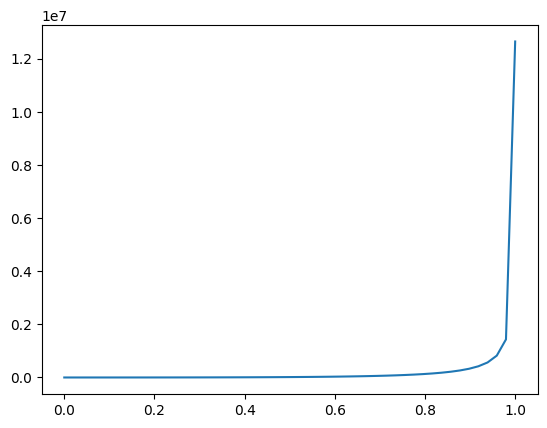

In [22]:
non_zero_county_od_pdf['cum_tons'].quantile(q=np.linspace(0,1,50)).plot()

In [27]:
# save as a parquet file to reduce file size
target_path = CACHE_PATH / 'data/transformed/county_od.parquet'
Path(os.path.dirname(target_path)).mkdir(parents=True,exist_ok=True)
county_od_pdf.to_parquet(target_path)